In [3]:
%reset -f

import spacy
from spacy.tokens import Doc
import re
import PyPDF2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import EarlyStoppingCallback


from sklearn.metrics import f1_score

In [4]:
test_df = pd.read_csv('../data/balanced dataset/test_dataset_208_new.csv')
# test_df = pd.read_csv('balanced dataset/test_dataset_208_new.csv')

# test_df = pd.read_csv('redacted_training_data.csv', sep=';')
# test_df = test_df.rename(columns={'is_goal': 'label'})
# def func(s):
#     if s == 'Y':
#         return 1
#     else:
#         return 0

# test_df['label'] = test_df['label'].apply(func)



action_statements = list(test_df['sentence'])

In [5]:
# Fourth stage - Inference
base_model = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(base_model)
action_statements_tokenized = tokenizer(action_statements, padding=True, truncation=True, max_length=512)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

test_dataset = Dataset(action_statements_tokenized)

model_path = '../models/mar29/checkpoint-160'
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
test_trainer = Trainer(model)


raw_pred, _, _ = test_trainer.predict(test_dataset)
y_pred = np.argmax(raw_pred, axis=1)

test_df['prediction'] = pd.Series(y_pred)
# y_pred = pd.Series(y_pred)
# goal_indices = list(y_pred[y_pred==1].index)

# c = 1
# for i in goal_indices:
#     print(f'Goal{c}')
#     print(action_statements[i])
#     print('')
#     c += 1

***** Running Prediction *****
  Num examples = 208
  Batch size = 8


In [6]:
confusion_matrix = pd.crosstab(test_df['label'], test_df['prediction'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0   1
Actual           
0          87  17
1          11  93


In [27]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

f1 = f1_score(test_df['label'], test_df['prediction'])
accuracy = accuracy_score(test_df['label'], test_df['prediction'])
precision = precision_score(test_df['label'], test_df['prediction'])
recall = recall_score(test_df['label'], test_df['prediction'])


print(f'F1 Score achieved: {f1:.2}')
print(f'Accuracy Score achieved: {accuracy:.2}')
print(f'Precision Score achieved: {precision:.2}')
print(f'Recall Score achieved: {recall:.2}')

F1 Score achieved: 0.87
Accuracy Score achieved: 0.87
Precision Score achieved: 0.85
Recall Score achieved: 0.89


In [8]:
confusion_matrix

Predicted,0,1
Actual,,
0,87,17
1,11,93


In [15]:
confusion_matrix.to_numpy()

array([[87, 17],
       [11, 93]])

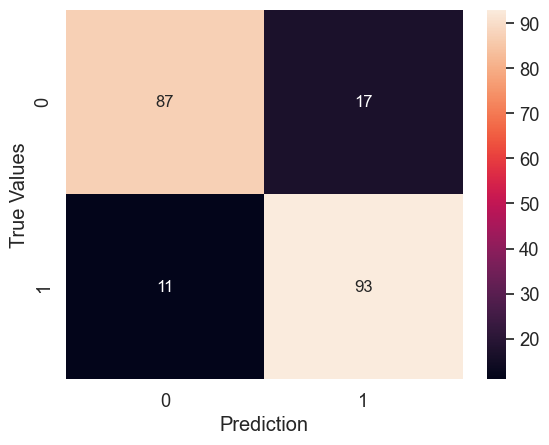

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# array = [[13,1,1,0,2,0],
#          [3,9,6,0,1,0],
#          [0,0,16,2,0,0],
#          [0,0,0,13,0,0],
#          [0,0,0,0,15,0],
#          [0,0,1,0,0,15]]

array = confusion_matrix.to_numpy()

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
# sn.set(font_scale=1.2) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

ax.set(ylabel='True Values', xlabel='Prediction')
plt.show()